In [16]:
import contextlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from val_utils import plot_compass_confusion_matrix_from_data, compute_stats

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Step 1: Combine

Start by combining model output with intern output for manual cross-checking

In [ ]:
INTERNS_GT_FP = ""
ground_truth = pd.read_csv(INTERNS_GT_FP).drop(columns="source")
ground_truth.head()

,county,state,feature,value,units,notes
0,Buena Vista,Iowa,structures (participating),NaN,NaN,NaN
1,Buena Vista,Iowa,structures (non-participating),"1,200",feet,CWEDs shall be setback a distance of no less t...
2,Buena Vista,Iowa,property line (participating),NaN,NaN,NaN
3,Buena Vista,Iowa,property line (non-participating),NaN,NaN,NaN
4,Buena Vista,Iowa,roads,NaN,NaN,NaN


In [ ]:
COMPASS_OUT_FP = ""
test = pd.read_csv(COMPASS_OUT_FP)
test.head()

,county,state,feature,value,units,source
0,Buena Vista,Iowa,structures (participating),NaN,NaN,https://buenavistacounty.iowa.gov/wp-content/u...
1,Buena Vista,Iowa,structures (non-participating),1.5,tip-height-multiplier,https://buenavistacounty.iowa.gov/wp-content/u...
2,Buena Vista,Iowa,property line (participating),NaN,NaN,https://buenavistacounty.iowa.gov/wp-content/u...
3,Buena Vista,Iowa,property line (non-participating),1.5,tip-height-multiplier,https://buenavistacounty.iowa.gov/wp-content/u...
4,Buena Vista,Iowa,roads,1.1,tip-height-multiplier,https://buenavistacounty.iowa.gov/wp-content/u...


In [13]:
pd.DataFrame(
    [f"{x[0][0]}, {x[0][1]}" for x in test.groupby(["county", "state"])]
).to_csv("counties.csv", index=False, header=["county"])

In [5]:
assert len(test) == len(ground_truth)

In [14]:
merged = ground_truth.merge(
    test,
    on=["county", "state", "feature"],
    suffixes=("_intern", "_compass")
)

assert len(merged) == len(ground_truth)
assert len(merged) == len(test)
merged.to_csv("side_by_side_compare.csv", index=False)

# Step 2: Perform manual cross-check

Color in cells and assign a score. Instructions for convering cell highlights (fill colors) to values **requires VBA**

---

### 1. Open the VBA Editor:

* Press `Alt + F11`

### 2. Insert a new module:

* `Insert` → `Module`

### 3. Paste this VBA function:

```vba
Function GetCellColor(rng As Range) As Long
    GetCellColor = rng.Interior.Color
End Function
```

### 4. Save and close the editor (`Ctrl + S` → close window)

---

### ✅ Now in Excel:

In a new column (e.g., column B), write:

```excel
=GetCellColor(A1)
```

Then drag down the formula. This will return a **numeric color code** for each cell in column A.

---

## 🧮 Count Cells by Fill Color:

To count how many cells have a specific color, first find the color code (e.g., from a specific cell):

```excel
=GetCellColor(A1)
```

Then use `COUNTIF` to count how many cells in the new column match that color:

```excel
=COUNTIF(B1:B100, GetCellColor(A1))
```


# Step 3: Read in check results and compute statistics

Key:

|Code| Descripton |
|----|------------|
| 10675893	|		Correct (DNE)	|
| 7592334	|		Correct (exists)	|
| 14791492	|		Intern value wrong, LLM correct	|
| 13463000	|		Intern value wrong, LLM wrong also	|
| 931198	|		Value does not exist but LLM reported it	|
| 3305961	|		Value Exists but LLM did not find	|
| 238	    |		Value exists but LLM got it wrong	|
| 49407	    |		Bad web scrape	|


In [ ]:
FORMATTED_COMPARISON_FP = ""
comparison = pd.read_csv(FORMATTED_COMPARISON_FP)
comparison.head()

,county,state,feature,value_interns,units_interns,notes_interns,value_compass,units_compass,extra_compass,Grader comments,Score
0,Buena Vista,Iowa,structures (participating),NaN,NaN,NaN,NaN,NaN,NaN,NaN,10675893
1,Buena Vista,Iowa,structures (non-participating),"1,200",feet,CWEDs shall be setback a distance of no less t...,1.5,tip-height-multiplier,1200 min dist,Bad instructions for interns,7592334
2,Buena Vista,Iowa,property line (participating),NaN,NaN,NaN,NaN,NaN,NaN,NaN,10675893
3,Buena Vista,Iowa,property line (non-participating),NaN,NaN,NaN,1.5,tip-height-multiplier,1200 min dist,Interns should be 1.1 tip-height-mult?,13463000
4,Buena Vista,Iowa,roads,NaN,NaN,NaN,1.1,tip-height-multiplier,NaN,Bad instructions for interns,7592334


In [7]:
print(len(comparison))
print(comparison.columns)

500
Index(['county', 'state', 'feature', 'value_interns', 'units_interns',
       'notes_interns', 'value_compass', 'units_compass', 'extra_compass',
       'Grader comments', 'Score'],
      dtype='object')


In [8]:
comparison["classification"] = comparison.Score.map(
    {
        10675893: "Correct (DNE)",
        7592334: "Correct (exists)",
        14791492: "Intern value wrong, LLM correct",
        13463000: "Intern value wrong, LLM wrong also",
        931198: "Value does not exist but LLM reported it",
        3305961: "Value exists but LLM did not find",
        238: "Value exists but LLM got it wrong",
        49407: "Bad web scrape",
    }
)
comparison["classification"].value_counts()

classification
Correct (DNE)                               265
Correct (exists)                            135
Value exists but LLM did not find            50
Bad web scrape                               25
Intern value wrong, LLM correct              11
Value exists but LLM got it wrong             7
Value does not exist but LLM reported it      5
Intern value wrong, LLM wrong also            2
Name: count, dtype: int64

In [9]:
correct_doc_compare = comparison[comparison["Score"] != 49407].copy()
correct_doc_compare

,county,state,feature,value_interns,units_interns,notes_interns,value_compass,units_compass,extra_compass,Grader comments,Score,classification
0,Buena Vista,Iowa,structures (participating),NaN,NaN,NaN,NaN,NaN,NaN,NaN,10675893,Correct (DNE)
1,Buena Vista,Iowa,structures (non-participating),"1,200",feet,CWEDs shall be setback a distance of no less t...,1.5,tip-height-multiplier,1200 min dist,Bad instructions for interns,7592334,Correct (exists)
2,Buena Vista,Iowa,property line (participating),NaN,NaN,NaN,NaN,NaN,NaN,NaN,10675893,Correct (DNE)
3,Buena Vista,Iowa,property line (non-participating),NaN,NaN,NaN,1.5,tip-height-multiplier,1200 min dist,Interns should be 1.1 tip-height-mult?,13463000,"Intern value wrong, LLM wrong also"
4,Buena Vista,Iowa,roads,NaN,NaN,NaN,1.1,tip-height-multiplier,NaN,Bad instructions for interns,7592334,Correct (exists)
...,...,...,...,...,...,...,...,...,...,...,...,...
495,Wells,North Dakota,decommissioning,Within 180 days of termination or abandonment ...,NaN,NaN,The Wells County Zoning Ordinance provides a r...,NaN,NaN,NaN,7592334,Correct (exists)
496,Wells,North Dakota,lighting,Wind turbines shall not be artificially lighte...,NaN,NaN,Wind turbines shall not be artificially lighte...,NaN,NaN,NaN,7592334,Correct (exists)
497,Wells,North Dakota,moratorium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10675893,Correct (DNE)
498,Wells,North Dakota,visual impact,Wind turbines shall be painted a non-reflectiv...,NaN,Advertisements not allowed. The permitee shall...,NaN,NaN,NaN,NaN,10675893,Correct (DNE)


In [10]:
correct_doc_compare["ordinance_value_exists"] = (
    correct_doc_compare["Score"].apply(
        lambda x: int(x in {7592334, 14791492, 13463000, 3305961, 238})
    )
)

# A few manual adjustments
correct_doc_compare.loc[
    (correct_doc_compare["county"] == "Bureau")
    & (correct_doc_compare["feature"] == "property line (participating)"),
    ["ordinance_value_exists", "Score"]
] = [0, 10675893]
correct_doc_compare.loc[
    (correct_doc_compare["county"] == "Bureau")
    & (correct_doc_compare["feature"] == "transmission"),
    ["ordinance_value_exists", "Score"]
] = [0, 10675893]
correct_doc_compare.loc[
    (correct_doc_compare["county"] == "Norman")
    & (correct_doc_compare["feature"] == "noise"),
    ["ordinance_value_exists", "Score"]
] = [0, 10675893]
correct_doc_compare.loc[
    (correct_doc_compare["county"] == "Rockingham")
    & (correct_doc_compare["feature"] == "special use districts"),
    ["ordinance_value_exists", "Score"]
] = [0, 10675893]


correct_doc_compare["ordinance_value_exists"].value_counts()

ordinance_value_exists
0    274
1    201
Name: count, dtype: int64

In [11]:
score_cats = {
    "dne_no_report": {10675893},
    "exists_report": {7592334, 14791492},
    "dne_report": {931198},
    "exists_bad_report": {13463000, 238},
    "exists_no_report": {3305961},
}

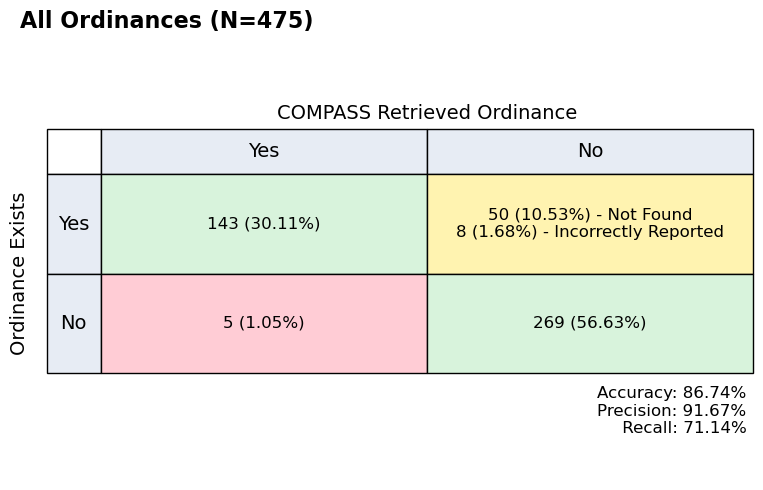

In [ ]:
plot_compass_confusion_matrix_from_data(
    correct_doc_compare,
    score_cats,
    title="All Ordinances",
    truth_labels_col="ordinance_value_exists",
    out_fp="plots/wind_validation_all_ordinances.png"
)

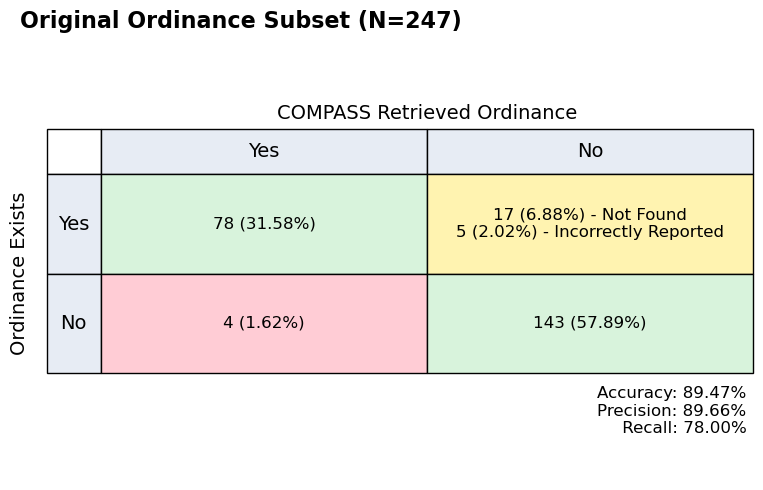

In [ ]:
original_feats = {
    'structures (participating)',
    'structures (non-participating)',
    'property line (participating)',
    'property line (non-participating)',
    'roads',
    'railroads',
    'transmission',
    'water',
    'noise',
    'maximum height',
    'minimum lot size',
    'shadow flicker',
    'tower density',
}
plot_compass_confusion_matrix_from_data(
    correct_doc_compare[correct_doc_compare["feature"].isin(original_feats)],
    score_cats,
    title="Original Ordinance Subset",
    truth_labels_col="ordinance_value_exists",
    out_fp="plots/wind_validation_original_subset.png"
)

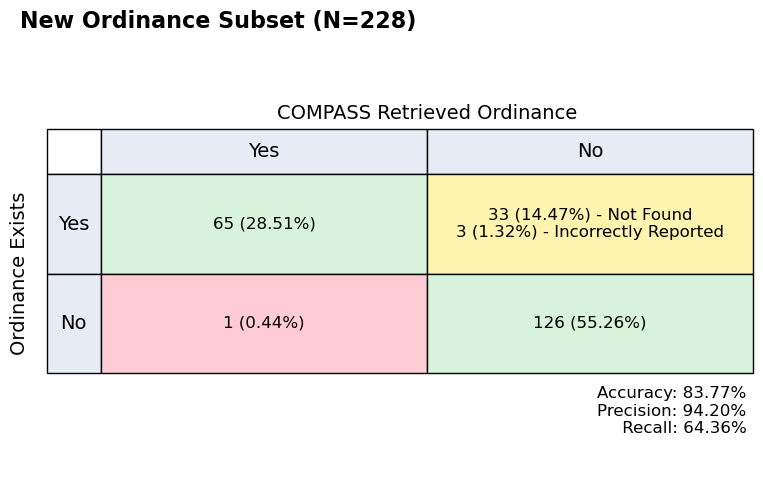

In [ ]:
plot_compass_confusion_matrix_from_data(
    correct_doc_compare[~correct_doc_compare["feature"].isin(original_feats)],
    score_cats,
    title="New Ordinance Subset",
    truth_labels_col="ordinance_value_exists",
    out_fp="plots/wind_validation_new_subset.png"
)

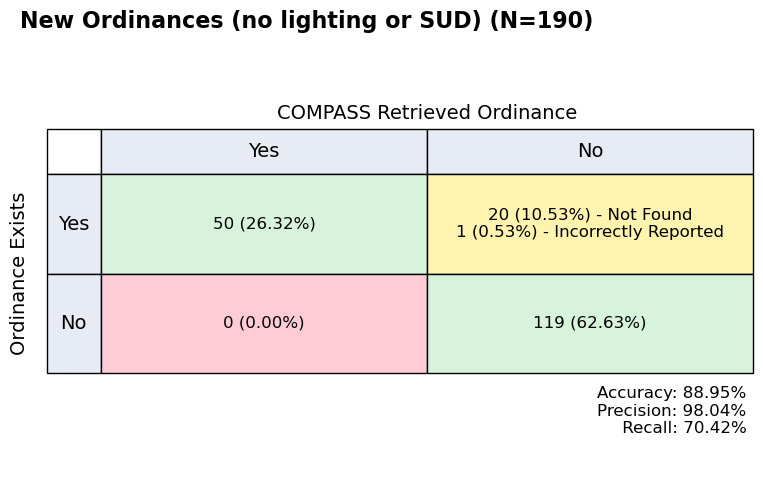

In [ ]:
exclude_feats = {
    'structures (participating)',
    'structures (non-participating)',
    'property line (participating)',
    'property line (non-participating)',
    'roads',
    'railroads',
    'transmission',
    'water',
    'noise',
    'maximum height',
    'minimum lot size',
    'shadow flicker',
    'tower density',
    "lighting",
    "special use districts",
}
plot_compass_confusion_matrix_from_data(
    correct_doc_compare[~correct_doc_compare["feature"].isin(exclude_feats)],
    score_cats,
    title="New Ordinances (no lighting or SUD)",
    truth_labels_col="ordinance_value_exists",
    out_fp="plots/wind_validation_new_subset_no_lsu.png"
)

In [ ]:
all_stats = []
for feature in correct_doc_compare["feature"].unique():
    data = correct_doc_compare[correct_doc_compare["feature"] == feature]
    __, a, p, r = compute_stats(
        data, score_cats, truth_labels_col="ordinance_value_exists"
    )
    num_values = data["ordinance_value_exists"].sum()
    num_found = (
        data["Score"].isin(
            score_cats["exists_report"]
            | score_cats["exists_bad_report"]
            | score_cats["dne_report"]
        )
    ).sum()
    num_found_correctly = (
        data["Score"].isin(score_cats["exists_report"])
    ).sum()

    all_stats.append(
        [
            feature,
            a * 100,
            p * 100,
            r * 100,
            num_values,
            num_found,
            num_found_correctly
        ]
    )

pra_breakdown = pd.DataFrame(
    all_stats,
    columns=[
        "feature",
        "Accuracy",
        "Precision",
        "Recall",
        "# non-null Ordinances",
        "# Ordinances reported by COMPASS",
        "# Ordinances correctly reported by COMPASS"
    ]
)

pra_breakdown.to_csv("pra_breakdown.csv", index=False)
pra_breakdown

/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home

,feature,Accuracy,Precision,Recall,# non-null Ordinances,# Ordinances reported by COMPASS,# Ordinances correctly reported by COMPASS
0,structures (participating),94.736842,100.000000,83.333333,6,5,5
1,structures (non-participating),94.736842,100.000000,94.444444,18,17,17
2,property line (participating),89.473684,50.000000,50.000000,2,2,1
3,property line (non-participating),57.894737,64.285714,52.941176,17,14,9
4,roads,78.947368,92.307692,80.000000,15,13,12
5,railroads,100.000000,100.000000,100.000000,4,4,4
6,transmission,89.473684,100.000000,75.000000,8,6,6
7,water,94.736842,100.000000,83.333333,6,5,5
8,noise,84.210526,100.000000,76.923077,13,10,10
9,maximum height,100.000000,100.000000,100.000000,3,3,3


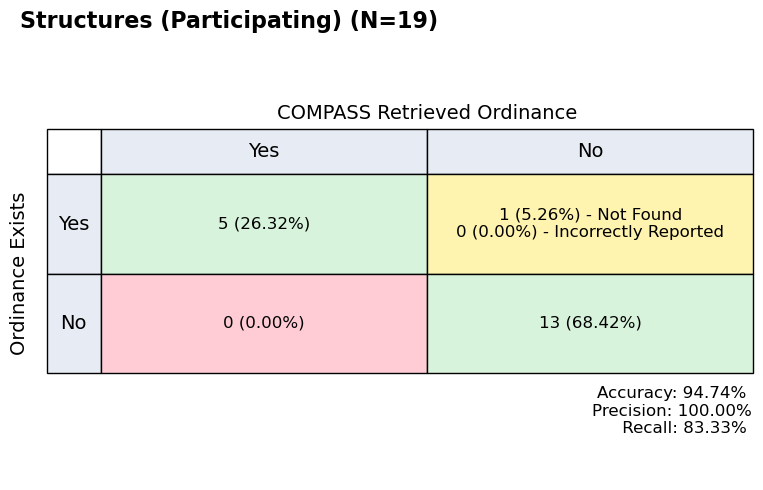

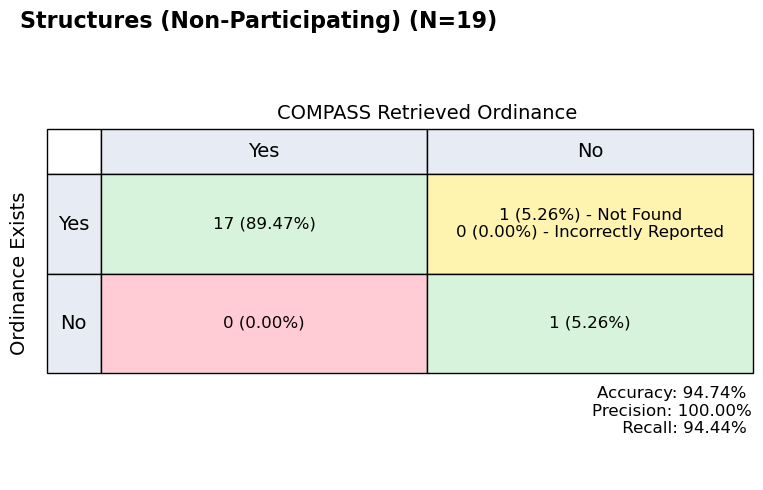

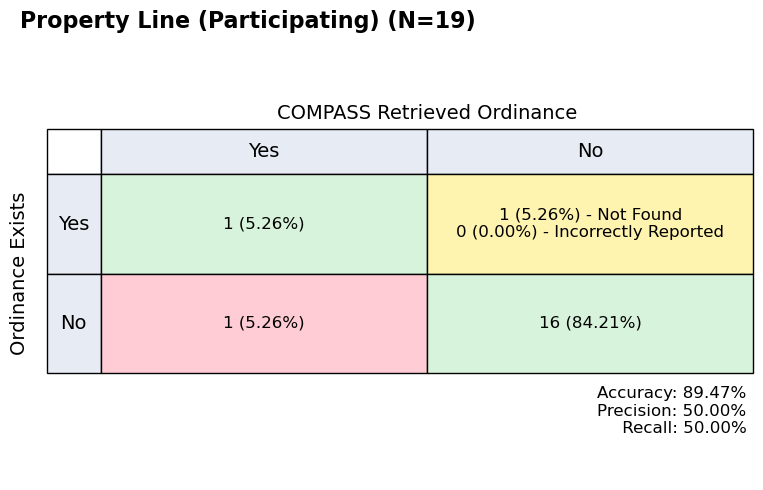

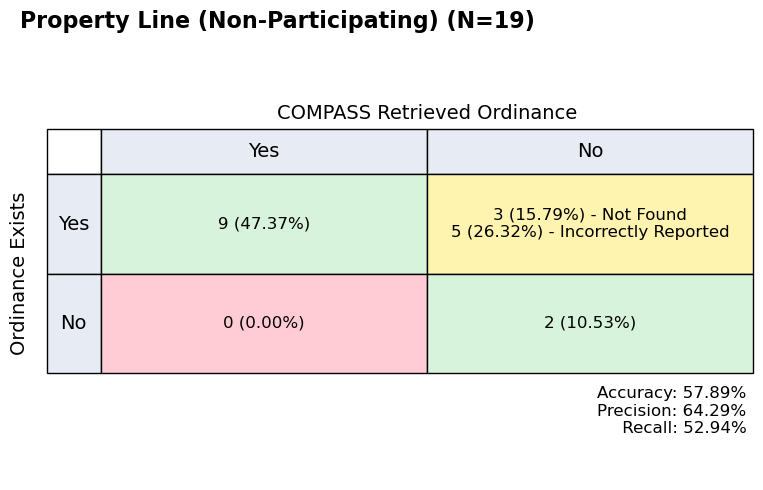

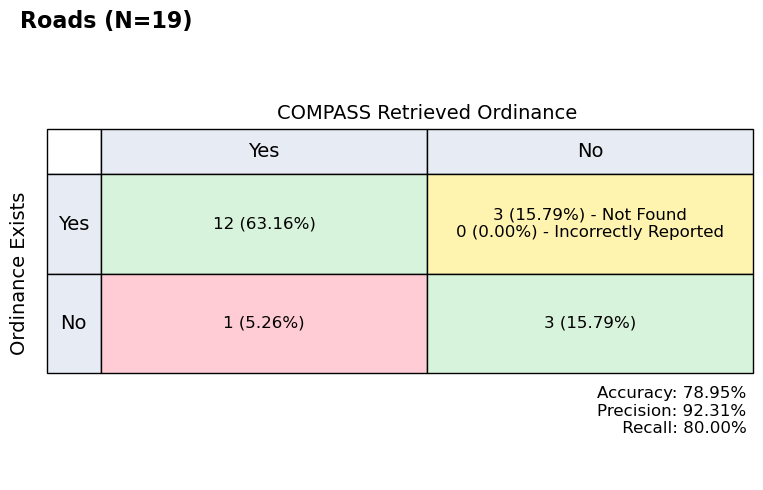

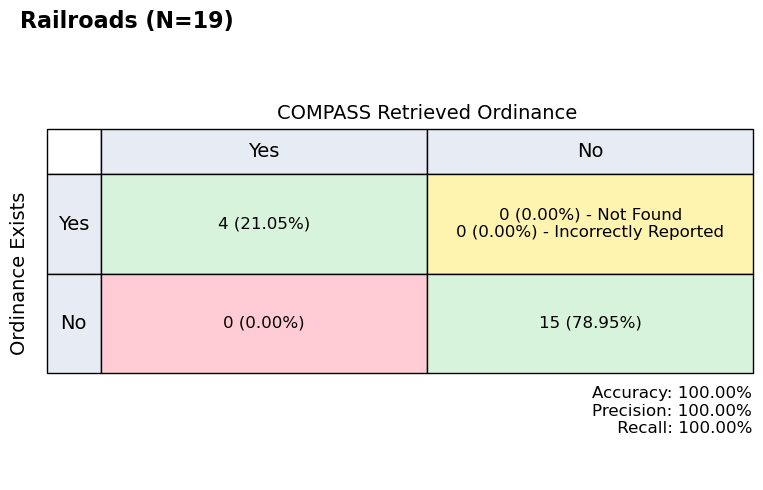

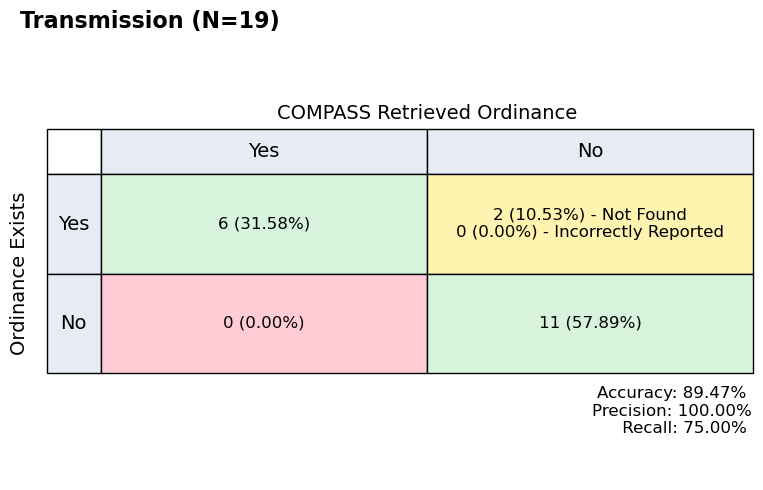

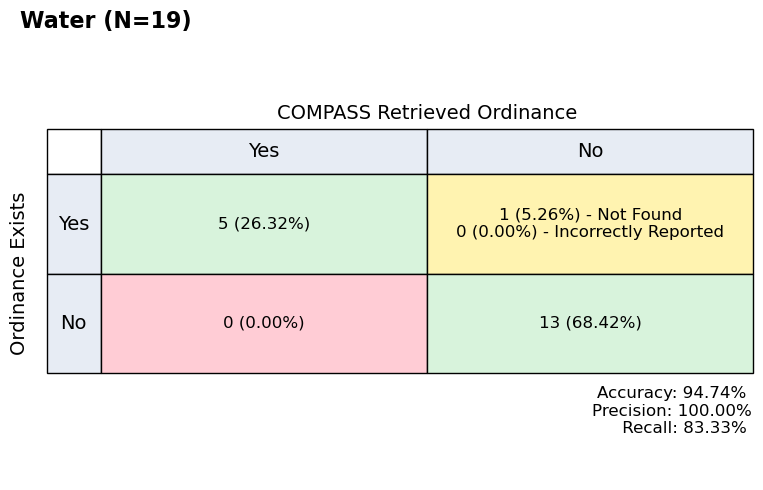

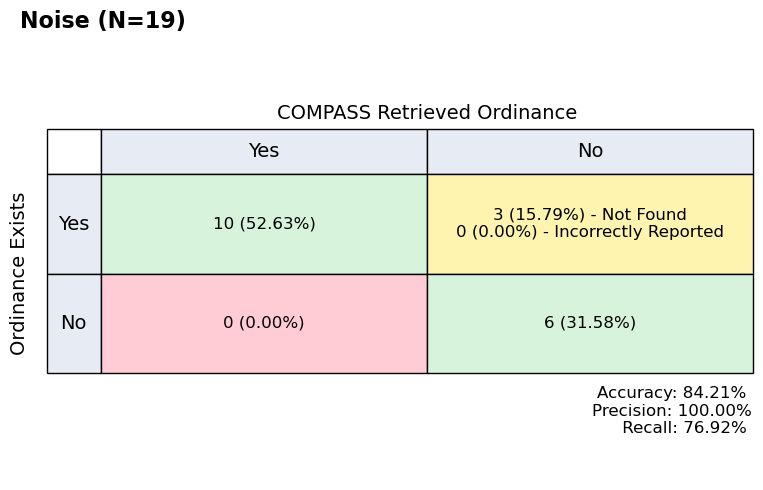

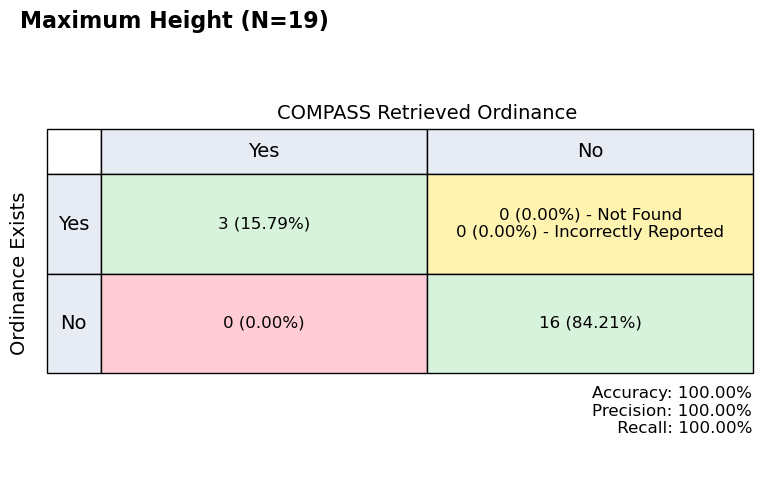

/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home

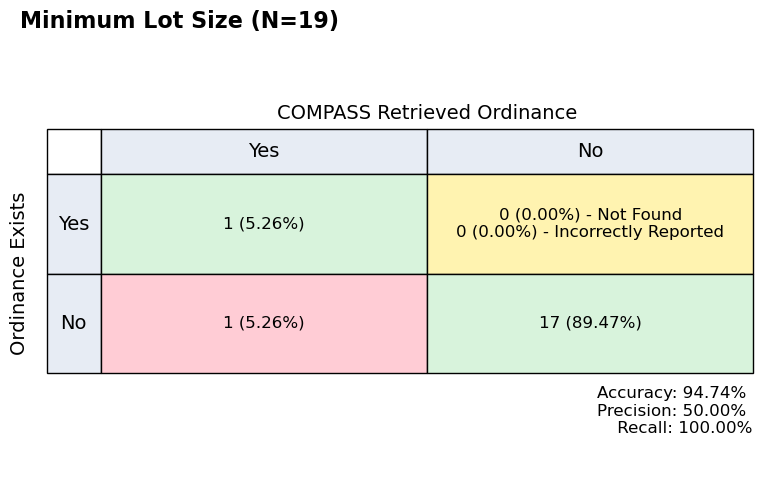

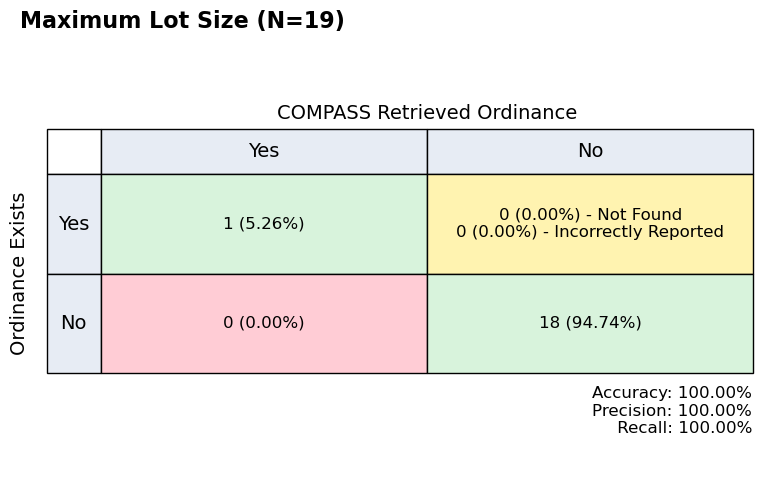

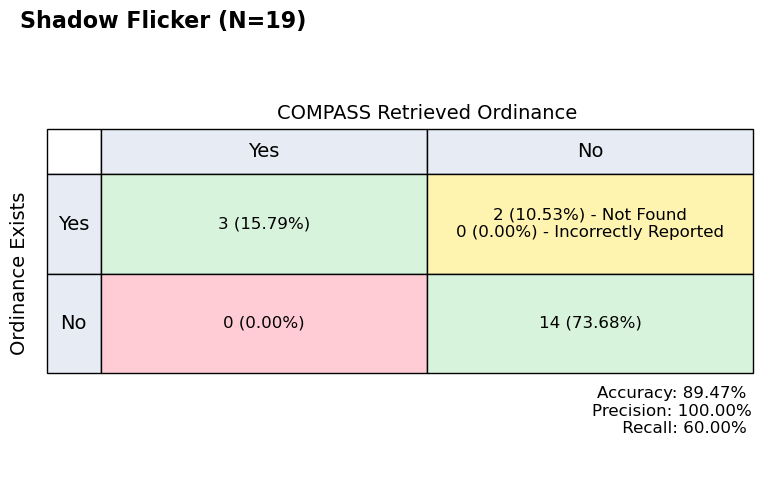

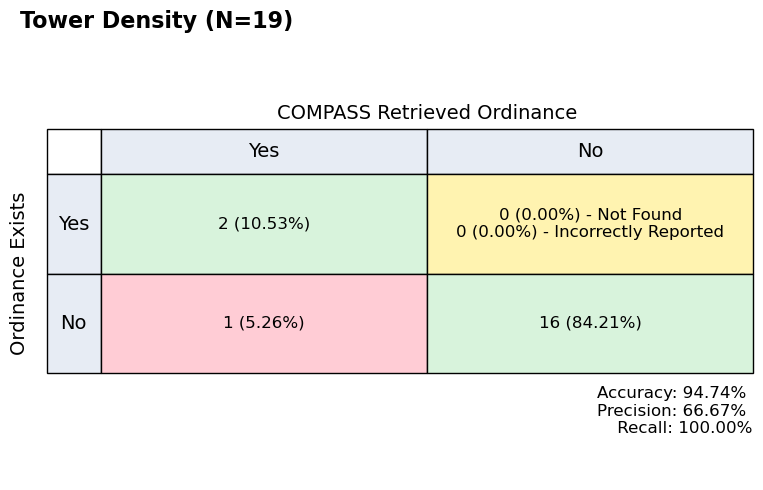

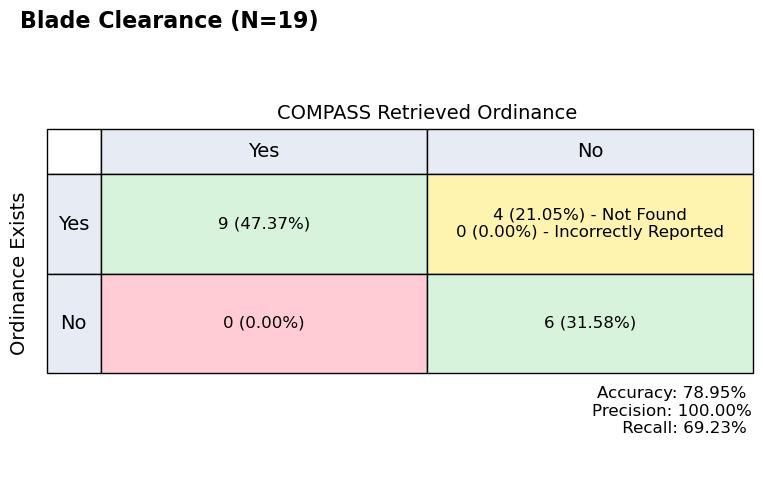

/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


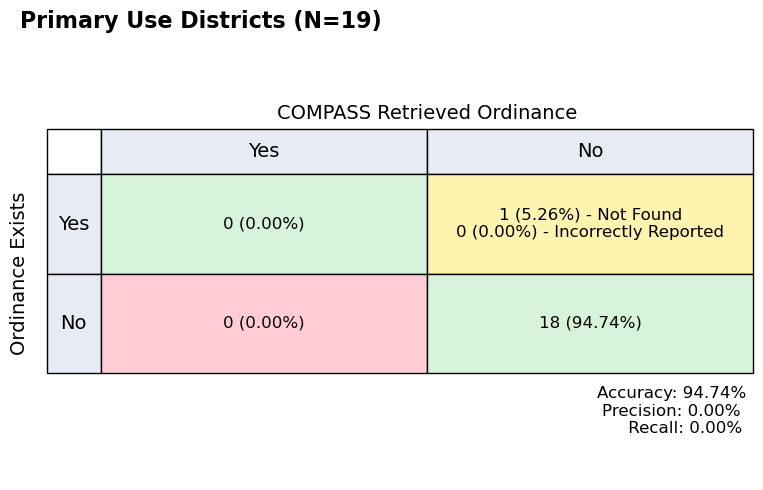

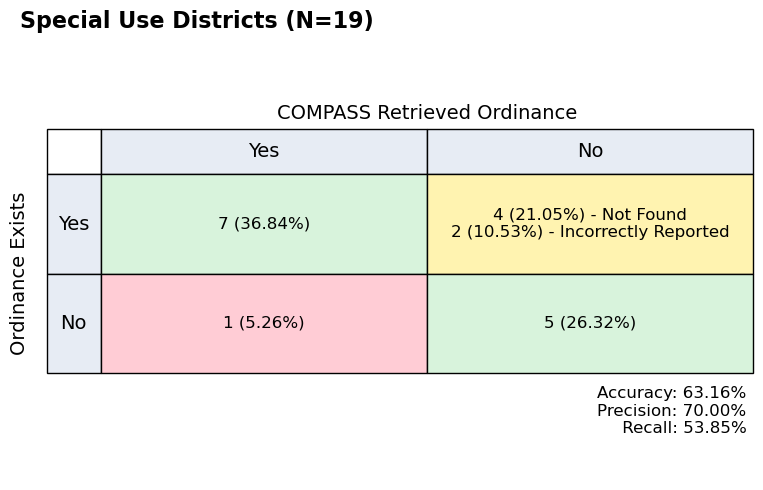

/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ppinchuk/gitrepos/COMPASS/.pixi/envs/pdev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


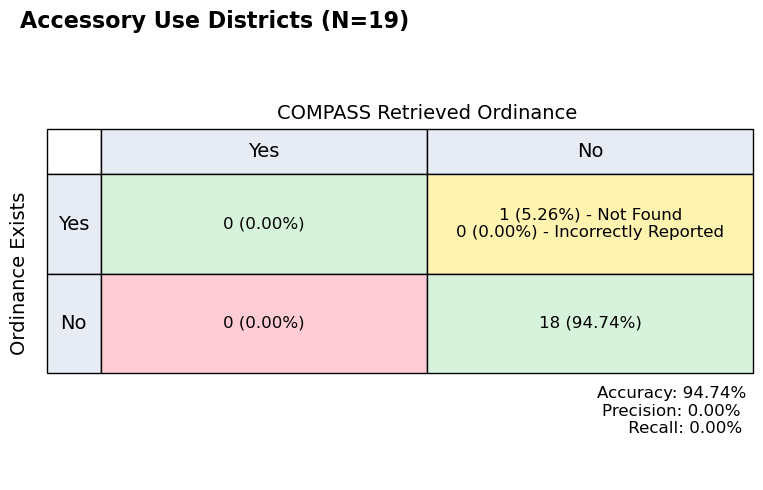

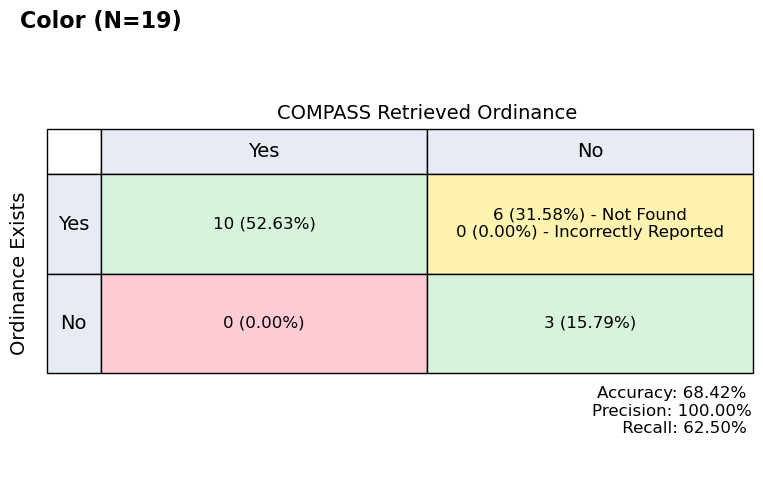

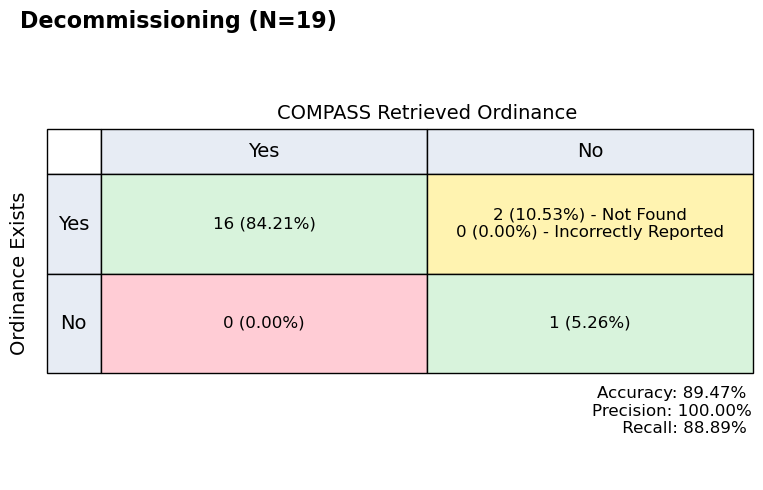

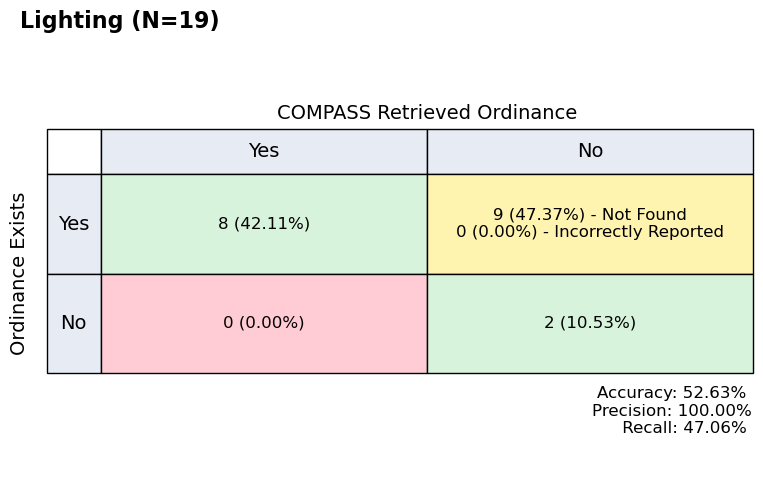

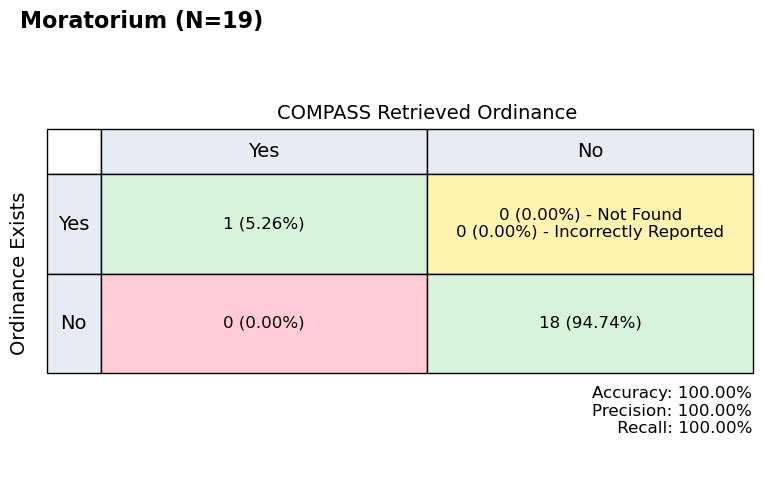

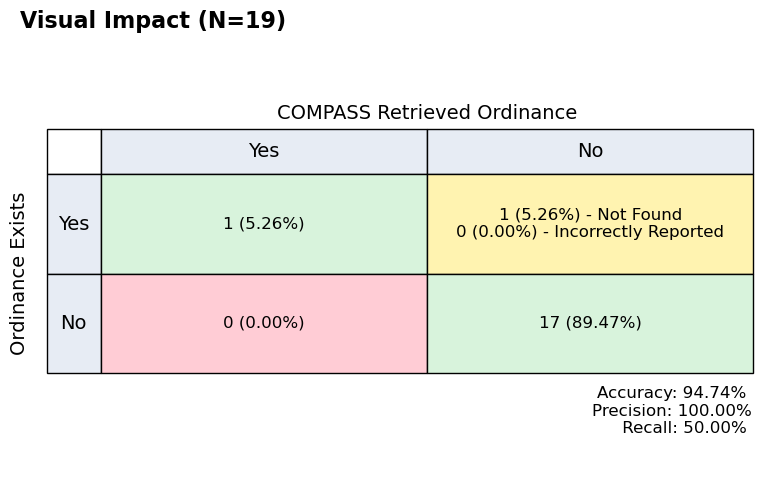

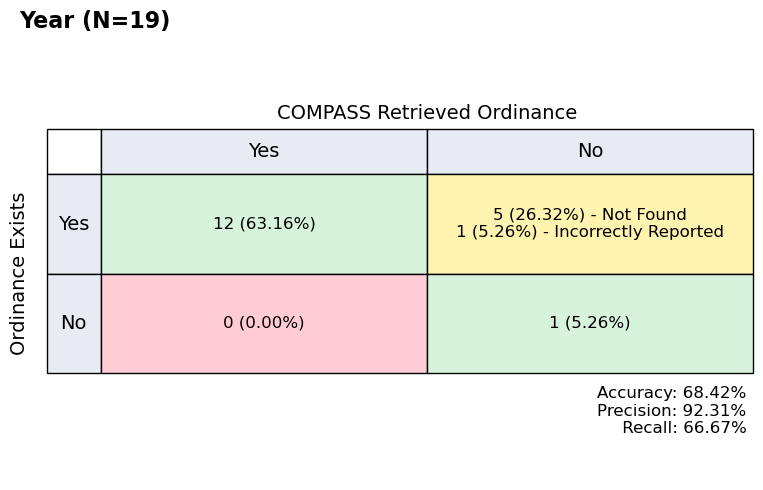

In [ ]:
for feature in correct_doc_compare["feature"].unique():
    data = correct_doc_compare[correct_doc_compare["feature"] == feature]
    with contextlib.suppress(IndexError):
        plot_compass_confusion_matrix_from_data(
            data,
            score_cats,
            title=feature.title(),
            truth_labels_col="ordinance_value_exists",
            out_fp=(
                f"plots/wind_validation_{feature}.png"
                .replace(" ", "_").replace("(", "").replace(")", "")
            )
        )